In [16]:
import pandas as pd
from database import select_dataset
import numpy as np

In [17]:
# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna().drop(columns=['Area'])
aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
aquastat = aquastat[aquastat.Variable != 'CI']
aquastat['Year'] = aquastat['Year'].astype(int)

evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar').drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')
wb_data['Year'] = wb_data['Year'].astype(int)

MWU_df = pd.concat([aquastat, evapotranspiration, cropcalendar, efficientwater, wb_data])

In [18]:
def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}
    
    non_item_df = df[~df.Variable.isin(itemized)].pivot(index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
    
    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    
    return data_dict

In [19]:
itemized = ['Kc', 'ICA']
data_dict = df_to_data_dict(MWU_df, itemized)
data_dict['LWU'] = 0

# Model

In [20]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import score_model, plot_diagnostic
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [21]:
model = EW_models['IWW_model']
X, y = get_X_y_from_data(model, data_dict)
res = model.run(X)

In [22]:
for model_name, model in EW_models.items():
    print(model_name, ': ')
    X, y = get_X_y_from_data(model, data_dict)
    res = model.run(X)
    print(score_model(model, X, y))

IWW_model : 
         r2  correlation        rmse Variable
0  0.734552     0.859789   31.102888      IWR
1  0.036750     0.657641  285.155347      IWW
2  0.603102     0.821737  153.740444      AWU
EW1_partial_model : 
         r2  correlation          rmse Variable
0  0.987684     0.993828      4.519458      TWW
1 -0.279845     0.443659  12512.483489      EW1
EW2_partial_model : 
         r2  correlation          rmse Variable
0  0.989336     0.995175   4272.565052      TFA
1 -0.404156     0.195124  57353.247805      EW2
EW1_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



         r2  correlation         rmse Variable
0  0.734552     0.859789    31.102888      IWR
1  0.036750     0.657641   285.155347      IWW
2  0.603102     0.821737   153.740444      AWU
3  0.813129     0.904383     1.014062      MWU
4  0.708943     0.862557   168.975281      TWW
5 -1.091887     0.405643  5222.323376      EW1
EW2_model : 


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



         r2  correlation          rmse Variable
0  0.734552     0.859789     31.102888      IWR
1  0.036750     0.657641    285.155347      IWW
2  0.603102     0.821737    153.740444      AWU
3  0.813129     0.904383      1.014062      MWU
4  0.989336     0.995175   4272.565052      TFA
5 -0.404156     0.195124  57353.247805      EW2


# Interface draft

## Model display

In [116]:
from models.Sarah.model_EW import MWU_nodes, EW1_nodes, concatenate_graph_specs
model = GraphModel(concatenate_graph_specs([MWU_nodes, EW1_nodes]))

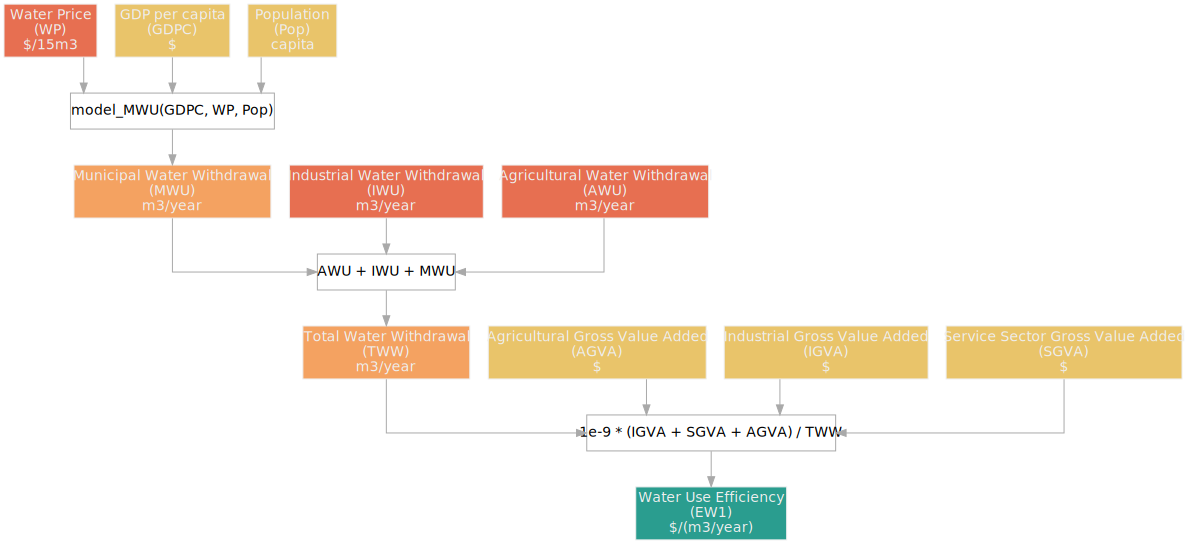

In [123]:
model.draw()

## Available data

In [118]:
def query_model_data(model, MWU_df):
    return MWU_df[MWU_df.Variable.isin(model.summary_df.index)]


def make_ISO_data_summary(ISO, model, data_dict):
    model_data_df = retrieve_model_data(model, data_dict)
    ISO_df = model_data_df[model_data_df.ISO == ISO]
    return pd.merge(ISO_df, model.summary_df, left_on='Variable', right_index=True)

In [119]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def plot_WU_data(df):
        
    fig = px.pie(df, values='Value', names='Variable', color='Variable', hole=0.5, hover_data=['Description', 'Unit'],
                color_discrete_map={'IWU':'#EF553B',
                                    'MWU':'#00CC96',
                                    'AWU': '#636EFA'})
    fig.update_layout(annotations=[dict(text='Water Use', x=0.5, y=0.5, font_size=20, showarrow=False)])

    return fig

def plot_GVA_data(df):
    fig = px.bar(df,
                 y='Value',
                 x='Variable')
    return fig

In [120]:
def MWU_subplot(data_summary_df):
    subplot = make_subplots(rows=1, cols=2,
                            specs=[[{"type": "scatter"}, {"type": "pie"}]],
                            subplot_titles=('Gross added values', 'Water Use'))
    
    WU_plot = plot_WU_data(data_summary_df[data_summary_df.Variable.isin(['AWU', 'IWU', 'MWU'])])
    GVA_plot = plot_GVA_data(data_summary_df[(data_summary_df.Variable.isin(['AGVA', 'IGVA', 'SGVA'])) & (data_summary_df.Year == 2019)])
    
    subplot.add_trace(GVA_plot['data'][0], row=1, col=1)
    subplot.add_trace(WU_plot['data'][0], row=1, col=2)
    subplot.update_layout(title_text="Water Model latest values")
   
    return subplot

In [121]:
data_summary_df = make_ISO_data_summary('HUN', model, MWU_df)
MWU_subplot(data_summary_df)